Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
import numpy as np
def wrangle(X):
  X = X.copy()
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  cols_with_zeros = ['longitude', 'latitude', 'construction_year', 'gps_height', 'population']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
#    X[col + '_Missing'] = X[col].isnull()
 
  
  cols_to_drop = ['id', 'quantity_group', 'payment_type', 'recorded_by', 'waterpoint_type_group', 'source_class', 'quality_group', 'num_private']
               
  X = X.drop(columns = cols_to_drop)
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format = True)
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns = 'date_recorded')

  X['years'] = X['year_recorded'] - X['construction_year']
  X['year_Missing'] = X['years'].isnull()
  return X

train = wrangle(train)
#val = wrangle(val)
test = wrangle(test)


In [4]:
train.loc[train['years'] < 0, 'years'] = 0
train['years'] = train['years'].replace(0, np.nan)
test.loc[train['years'] < 0, 'years'] = 0
test['years'] = train['years'].replace(0, np.nan)

In [5]:
target = 'status_group'
train_features = train.drop(columns = [target, 'year_recorded'])
numeric_features = train_features.select_dtypes(include = 'number').columns.tolist()
cardinality = train_features.select_dtypes(exclude = 'number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
features = numeric_features + categorical_features

train, val = train_test_split(train, train_size = 0.80, test_size = 0.20, 
                              stratify = train['status_group'], random_state = 42)


X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

import category_encoders as ce 
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names = True),
    SimpleImputer(strategy = 'median'),
    RandomForestClassifier(n_estimators = 100, random_state = 0, n_jobs = -1)
)
pipeline.fit(X_train, y_train)
print('Train: ', pipeline.score(X_train, y_train))
print('Validatiion: ', pipeline.score(X_val, y_val))

Train:  0.9979166666666667
Validatiion:  0.8084175084175084


In [12]:
from sklearn.model_selection import cross_val_score
k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv = k, 
                        scoring = 'accuracy')
print(f'accuracy score {k} folds: ', scores)

accuracy score 3 folds:  [0.79286616 0.80075758 0.79469697]


In [17]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state = 42)
)
param_distrib = {
    'simpleimputer__strategy': ['median', 'mean'],
    'randomforestclassifier__n_estimators' : randint(200, 400),
    'randomforestclassifier__max_depth' : [5, 10, 15, None],
    'randomforestclassifier__max_features': uniform(0, 1),
}

In [18]:
search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distrib,
    n_iter = 5,
    cv = 3,
    scoring = 'accuracy',
    verbose = 10,
    return_train_score = True,
    n_jobs = 7
)
search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 out of  15 | elapsed:   23.8s remaining:  1.1min
[Parallel(n_jobs=7)]: Done   6 out of  15 | elapsed:   29.2s remaining:   43.8s
[Parallel(n_jobs=7)]: Done   8 out of  15 | elapsed:   52.5s remaining:   45.9s
[Parallel(n_jobs=7)]: Done  10 out of  15 | elapsed:   52.8s remaining:   26.3s
[Parallel(n_jobs=7)]: Done  12 out of  15 | elapsed:  1.0min remaining:   15.6s
[Parallel(n_jobs=7)]: Done  15 out of  15 | elapsed:  1.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [19]:
print('param', search.best_params_)
print('score', search.best_score_)

param {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 0.08803315913328014, 'randomforestclassifier__n_estimators': 378, 'simpleimputer__strategy': 'median'}
score 0.7911616161616162


In [20]:
from sklearn.metrics import accuracy_score
pipeline = search.best_estimator_
val_pred = pipeline.predict(X_val)
score = accuracy_score(y_val, val_pred)
print(score)

0.7989057239057239


In [6]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in c:\users\iulia\anaconda3\lib\site-packages (0.22.1)


In [7]:
import sklearn
sklearn.__version__

'0.22.1'

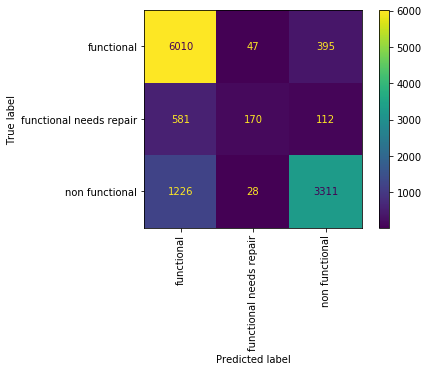

In [21]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format = '.0f', xticks_rotation = 'vertical');